# Imports

In [1]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plot_fairness_metrics import *

pip install 'aif360[inFairness]'


# Dataset cleaning (all features need to be numeric)

In [2]:
df = pd.read_csv('complete_df_with_predictions.csv')
df_copied = df.copy()
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']
df.drop(columns=predicted_cols, inplace=True)

In [3]:
df.dtypes

Unnamed: 0           int64
decile3            float64
ID                   int64
decile1            float64
race               float64
lsat               float64
ugpa               float64
zfygpa             float64
grad                 int64
zgpa               float64
bar1                 int64
bar1_yr            float64
bar2                 int64
bar2_yr            float64
fam_inc            float64
parttime           float64
male               float64
race2               object
pass_bar             int64
bar                 object
tier               float64
academic_career    float64
race1_black           bool
race1_hisp            bool
race1_other           bool
race1_white           bool
race1               object
dtype: object

In [4]:
race_enc = LabelEncoder()
df['race1_encoded'] = race_enc.fit_transform(df['race1'])
df

,Unnamed: 0,decile3,ID,decile1,race,lsat,ugpa,zfygpa,grad,zgpa,...,pass_bar,bar,tier,academic_career,race1_black,race1_hisp,race1_other,race1_white,race1,race1_encoded
0,0,10.0,2,10.0,7.0,44.0,3.5,1.33,1,1.88,...,1,a Passed 1st time,4.0,1.341087,False,False,False,True,white,4
1,1,4.0,3,5.0,7.0,29.0,3.5,-0.11,1,-0.57,...,1,a Passed 1st time,2.0,-0.385252,False,False,False,True,white,4
2,2,2.0,36,3.0,7.0,36.0,3.5,-0.64,1,-1.12,...,1,a Passed 1st time,3.0,-0.355093,False,False,False,True,white,4
3,3,4.0,52,7.0,7.0,39.0,3.5,0.34,1,-0.49,...,1,a Passed 1st time,3.0,0.217453,False,False,False,True,white,4
4,4,8.0,55,9.0,7.0,48.0,3.5,1.02,1,0.76,...,1,a Passed 1st time,5.0,1.144843,False,False,False,True,white,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,22402,1.0,10695,3.0,3.0,26.5,1.8,-0.58,1,-1.49,...,0,c Failed,1.0,-1.922560,True,False,False,False,black,1
22068,22403,1.0,19642,3.0,3.0,19.7,1.8,-0.64,1,-1.36,...,0,c Failed,1.0,-2.216261,True,False,False,False,black,1
22069,22404,8.0,24704,7.0,3.0,36.0,1.8,0.41,1,0.80,...,1,a Passed 1st time,3.0,-0.613914,True,False,False,False,black,1
22070,22405,10.0,10000,10.0,7.0,44.0,1.5,1.88,1,1.42,...,1,a Passed 1st time,3.0,0.134185,False,False,False,True,white,4


In [5]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df = df[keep]
df.dtypes

Unnamed: 0           int64
bar2                 int64
race1_white           bool
fam_inc            float64
race1_hisp            bool
race1_other           bool
academic_career    float64
male               float64
decile3            float64
bar2_yr            float64
ID                   int64
lsat               float64
ugpa               float64
grad                 int64
race               float64
zfygpa             float64
bar1_yr            float64
race1_black           bool
decile1            float64
pass_bar             int64
race1_encoded        int32
bar1                 int64
tier               float64
zgpa               float64
parttime           float64
dtype: object

# Split Train and Test

In [6]:
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race1_encoded']

target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [7]:
df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

# Apply Techniques to train

### Custom reweighing

In [8]:
def compute_individual_weights(df, label_col, protected_attr_col):
    # Compute weights for one protected attribute
    joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
    attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
    attr_counts.columns = [protected_attr_col, 'attr_prob']
    label_counts = df[label_col].value_counts(normalize=True).reset_index()
    label_counts.columns = [label_col, 'label_prob']

    weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
    weights_df = weights_df.merge(label_counts, on=label_col)

    weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))

    return weights_df[[protected_attr_col, label_col, 'weight']]

def compute_combined_weights(df, label_col, protected_attrs):
    df = df.copy()
    df['weight'] = 1.0  # Start with neutral weights

    for attr in protected_attrs:
        w = compute_individual_weights(df, label_col, attr)
        w = w.rename(columns={'weight': f'weight_{attr}'})
        df = df.merge(w, on=[attr, label_col], how='left')
        df['weight'] *= df[f'weight_{attr}']  # Multiply in the new weight

    return df


In [9]:
protected_attributes = ['race1_encoded', 'tier', 'fam_inc']
df_train_weighted = compute_combined_weights(df_train, label_col=target, protected_attrs=protected_attributes)

In [10]:
X_train_weighted = df_train_weighted[features]
y_train_weighted = df_train_weighted[target]

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score


fbeta_scorer = make_scorer(fbeta_score, beta=1.41, pos_label=0)

In [12]:
from xgboost import XGBClassifier
import numpy as np

ratio = np.sum(y_train_weighted == 0) / np.sum(y_train_weighted == 1)
xgb_best_model_regul = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=ratio, reg_alpha=5, reg_lambda=5, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100)  
xgb_best_model_regul.fit(X_train_weighted, y_train_weighted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix


y_pred_xgb = xgb_best_model_regul.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[ 194   33]
 [ 947 3241]]
              precision    recall  f1-score   support

           0       0.17      0.85      0.28       227
           1       0.99      0.77      0.87      4188

    accuracy                           0.78      4415
   macro avg       0.58      0.81      0.58      4415
weighted avg       0.95      0.78      0.84      4415



### quantile binning suppression

In [14]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

def suppress_protected_feature_signals(df, protected_attrs, n_bins=5, strategy='quantile'):
    df_transformed = df.copy()

    for feature in protected_attrs:
        if pd.api.types.is_numeric_dtype(df_transformed[feature]):
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
            df_transformed[feature] = discretizer.fit_transform(df_transformed[[feature]])
        else:
            raise ValueError(f"Feature '{feature}' must be numeric for binning.")

    return df_transformed


In [15]:
protected_attributes = ['race1_encoded', 'tier', 'fam_inc']
df_train_transformed = suppress_protected_feature_signals(df_train, protected_attrs=protected_attributes, n_bins=5)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [16]:
X_train_transformed = df_train_transformed[features]
y_train_transformed = df_train_transformed[target]

In [17]:
from xgboost import XGBClassifier
import numpy as np

ratio = np.sum(y_train_transformed == 0) / np.sum(y_train_transformed == 1)
xgb_best_model_regul_2 = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=ratio, reg_alpha=5, reg_lambda=5, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100)  
xgb_best_model_regul_2.fit(X_train_transformed, y_train_transformed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [18]:
y_pred_xgb_2 = xgb_best_model_regul_2.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb_2))
print(classification_report(y_test, y_pred_xgb_2))

[[ 187   40]
 [ 876 3312]]
              precision    recall  f1-score   support

           0       0.18      0.82      0.29       227
           1       0.99      0.79      0.88      4188

    accuracy                           0.79      4415
   macro avg       0.58      0.81      0.58      4415
weighted avg       0.95      0.79      0.85      4415



### Quantile-based Distribution Alignment

In [19]:
import numpy as np
import pandas as pd

def add_noise_to_biased_features(df, feature_cols, noise_std=0.2, seed=42):
    df = df.copy()
    np.random.seed(seed)

    for feature in feature_cols:
        std_dev = df[feature].std()
        noise = np.random.normal(loc=0.0, scale=noise_std * std_dev, size=len(df))
        new_col = f"{feature}_debiased"
        df[new_col] = df[feature] + noise

    return df


In [20]:
features_to_repair = ['race1_encoded', 'tier', 'fam_inc']
df_train_repaired = add_noise_to_biased_features(df_train, features_to_repair)

In [21]:
X_train_repaired = df_train_repaired[features]
y_train_repaired = df_train_repaired[target]

In [22]:
from xgboost import XGBClassifier
import numpy as np

ratio = np.sum(y_train_repaired == 0) / np.sum(y_train_repaired == 1)
xgb_best_model_regul_3 = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=ratio, reg_alpha=5, reg_lambda=5, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100)  
xgb_best_model_regul_3.fit(X_train_repaired, y_train_repaired)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [23]:
y_pred_xgb_3 = xgb_best_model_regul_3.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb_3))
print(classification_report(y_test, y_pred_xgb_3))

[[ 194   33]
 [ 947 3241]]
              precision    recall  f1-score   support

           0       0.17      0.85      0.28       227
           1       0.99      0.77      0.87      4188

    accuracy                           0.78      4415
   macro avg       0.58      0.81      0.58      4415
weighted avg       0.95      0.78      0.84      4415



### Actual Reweighing

In [24]:
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing

def apply_reweighing(df, label_col, protected_attrs, privileged_vals, favorable_val=1):
    # Prepare dataset
    dataset = StandardDataset(
        df,
        label_name=label_col,
        favorable_classes=[favorable_val],
        protected_attribute_names=protected_attrs,
        privileged_classes=[[v] for v in privileged_vals]
    )

    # Construct unprivileged groups as the cross-product of all non-privileged values
    unprivileged_groups = [
        {attr: val for attr, val in zip(protected_attrs, combo)}
        for combo in (
            __import__('itertools').product(*[
                set(df[attr]) - {pval} for attr, pval in zip(protected_attrs, privileged_vals)
            ])
        )
    ]

    # Apply reweighing
    rw = Reweighing(
        privileged_groups=[{attr: val} for attr, val in zip(protected_attrs, privileged_vals)],
        unprivileged_groups=unprivileged_groups
    )
    dataset_rw = rw.fit_transform(dataset)
    df_rw, _ = dataset_rw.convert_to_dataframe()

    # Add weights
    df_rw['instance_weight'] = dataset_rw.instance_weights

    return df_rw


In [25]:
features_to_repair = ['race1_encoded', 'tier', 'fam_inc']
privileged_values = [4, 6, 5]  # Adjust to match your context
df_train_rw = apply_reweighing(df_train, label_col='pass_bar', protected_attrs=features_to_repair, privileged_vals=privileged_values)

In [26]:
X_train_rw = df_train_rw[features]
y_train_rw = df_train_rw[target]

In [27]:
ratio = np.sum(y_train_rw == 0) / np.sum(y_train_rw == 1)
xgb_best_model_regul_4 = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=ratio, reg_alpha=5, reg_lambda=5, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100)  
xgb_best_model_regul_4.fit(X_train_rw, y_train_rw)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [28]:
y_pred_xgb_4 = xgb_best_model_regul_4.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb_4))
print(classification_report(y_test, y_pred_xgb_4))

[[ 194   33]
 [ 947 3241]]
              precision    recall  f1-score   support

           0       0.17      0.85      0.28       227
           1       0.99      0.77      0.87      4188

    accuracy                           0.78      4415
   macro avg       0.58      0.81      0.58      4415
weighted avg       0.95      0.78      0.84      4415



# Apply techniques to whole dataset

In [29]:
def compute_individual_weights(df, label_col, protected_attr_col):
    # Compute weights for one protected attribute
    joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
    attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
    attr_counts.columns = [protected_attr_col, 'attr_prob']
    label_counts = df[label_col].value_counts(normalize=True).reset_index()
    label_counts.columns = [label_col, 'label_prob']

    weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
    weights_df = weights_df.merge(label_counts, on=label_col)

    weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))

    return weights_df[[protected_attr_col, label_col, 'weight']]

def compute_combined_weights(df, label_col, protected_attrs):
    df = df.copy()
    df['weight'] = 1.0  # Start with neutral weights

    for attr in protected_attrs:
        w = compute_individual_weights(df, label_col, attr)
        w = w.rename(columns={'weight': f'weight_{attr}'})
        df = df.merge(w, on=[attr, label_col], how='left')
        df['weight'] *= df[f'weight_{attr}']  # Multiply in the new weight

    return df


In [30]:
protected_attributes = ['race1_encoded', 'tier', 'fam_inc']
df_weighted = compute_combined_weights(df, label_col=target, protected_attrs=protected_attributes)


In [31]:
pass_bar_rf_race = xgb_best_model_regul.predict(df_weighted[features])
df_weighted['pass_bar_xgb_weighted'] = pass_bar_rf_race

### technique 2

In [32]:
protected_attributes = ['race1_encoded', 'tier', 'fam_inc']
df_transformed = suppress_protected_feature_signals(df, protected_attrs=protected_attributes, n_bins=5)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [33]:
pass_bar_rf_2 = xgb_best_model_regul_2.predict(df_transformed[features])
df_transformed['pass_bar_xgb_transformed'] = pass_bar_rf_2

### technique 3

In [34]:
features_to_repair = ['race1_encoded', 'tier', 'fam_inc']
df_repaired = add_noise_to_biased_features(df, features_to_repair)

In [35]:
pass_bar_rf_3 = xgb_best_model_regul_3.predict(df_repaired[features])
df_repaired['pass_bar_xgb_repaired'] = pass_bar_rf_3

### Actual reweighing

In [36]:
features_to_repair = ['race1_encoded', 'tier', 'fam_inc']
privileged_values = [4, 6, 5]  # Adjust to match your context
df_rw = apply_reweighing(df, label_col='pass_bar', protected_attrs=features_to_repair, privileged_vals=privileged_values)

In [37]:
pass_bar_rf_4 = xgb_best_model_regul_4.predict(df_rw[features])
df_rw['pass_bar_xgb_rw'] = pass_bar_rf_4

# Check for bias

### technique 1

In [38]:
df_weighted['race1'] = df_copied['race1']

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

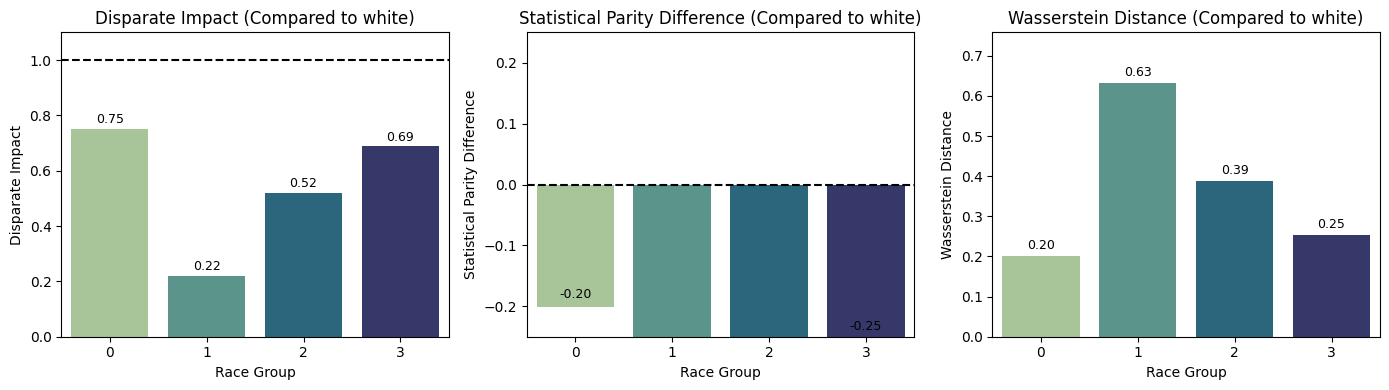

In [39]:
race_groups = [0, 1, 2, 3]
results = get_DI_SPD_WD(race_groups, df_weighted, 'race1_encoded', 4, 'pass_bar_xgb_weighted')
plot_fairness_metrics(results, 'Race Group', 'white')

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

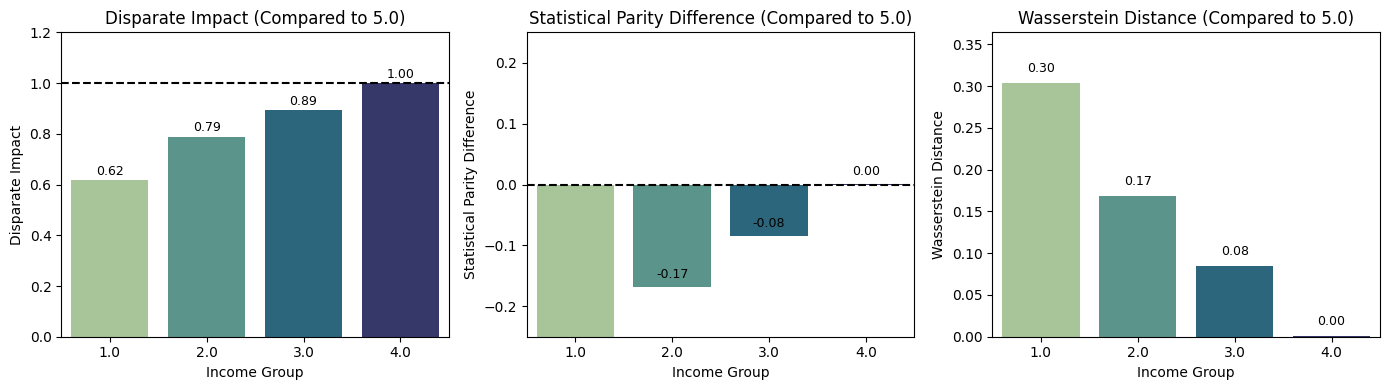

In [40]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df_weighted, 'fam_inc', 5.0, 'pass_bar_xgb_weighted')
plot_fairness_metrics(results, 'Income Group', 5.0)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

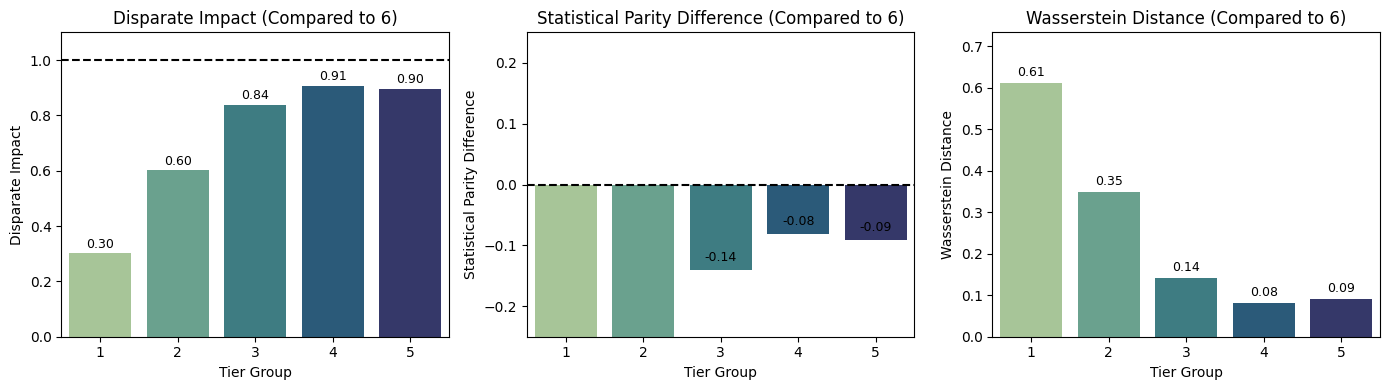

In [41]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df_weighted, 'tier', 6, 'pass_bar_xgb_weighted')
plot_fairness_metrics(results, 'Tier Group', 6)

### Second technique bias

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

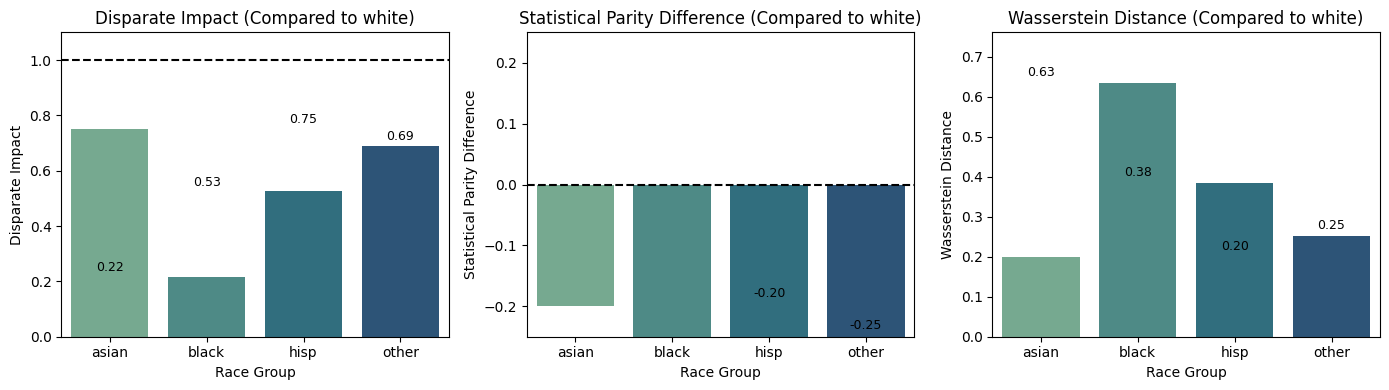

In [45]:
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_xgb_transformed')
plot_fairness_metrics(results, 'Race Group', 'white')

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

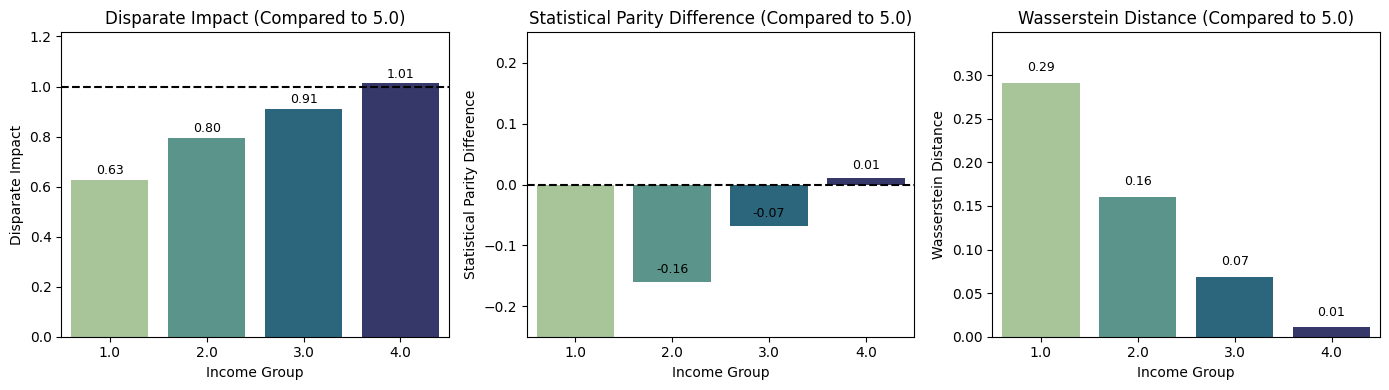

In [46]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_xgb_transformed')
plot_fairness_metrics(results, 'Income Group', 5.0)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

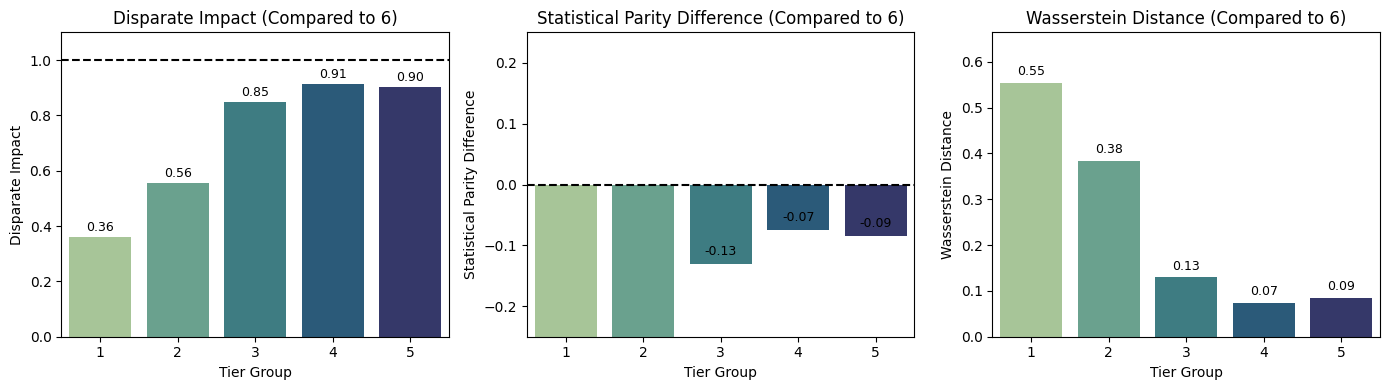

In [47]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_xgb_transformed')
plot_fairness_metrics(results, 'Tier Group', 6)

### technique 3

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

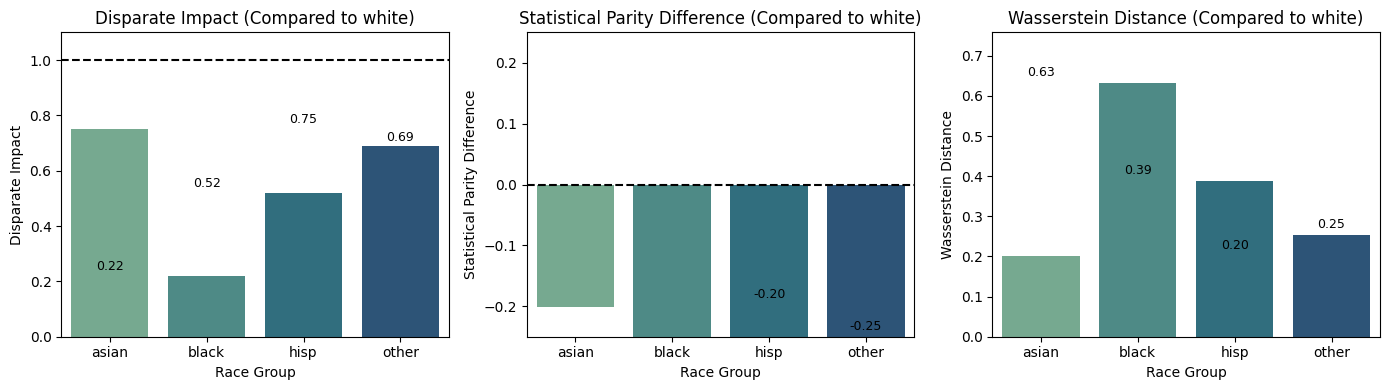

In [48]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_xgb_repaired')
plot_fairness_metrics(results, 'Race Group', 'white')

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

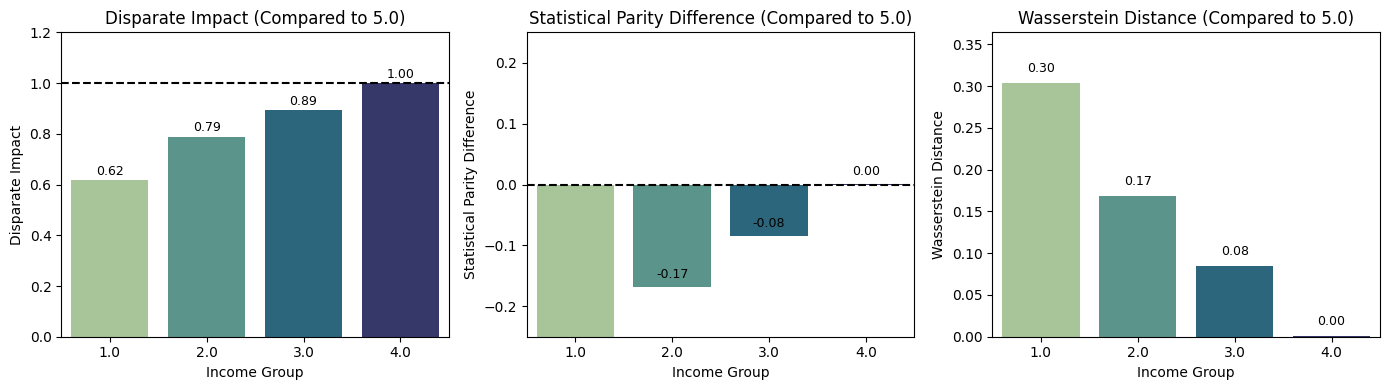

In [49]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_xgb_repaired')
plot_fairness_metrics(results, 'Income Group', 5.0)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

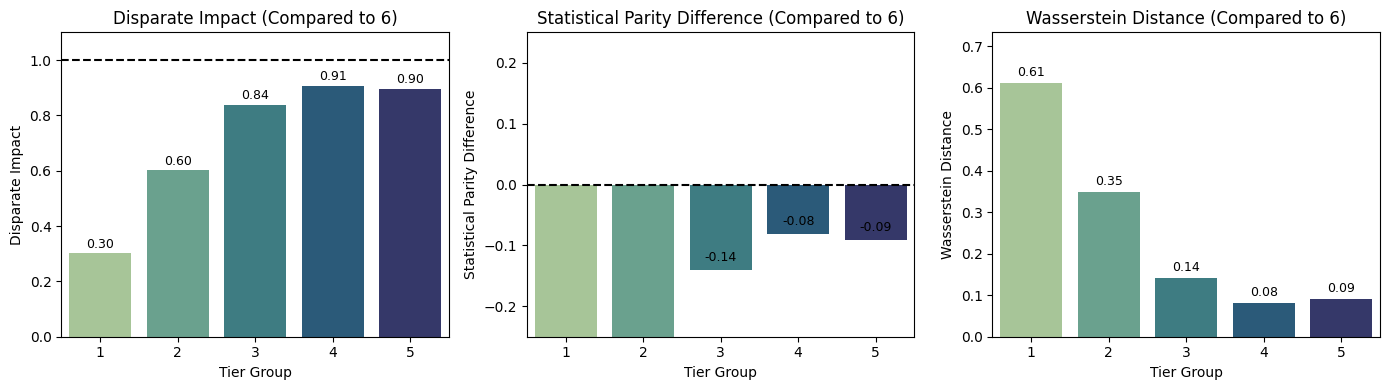

In [50]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_xgb_repaired')
plot_fairness_metrics(results, 'Tier Group', 6)

### Acual Rw

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

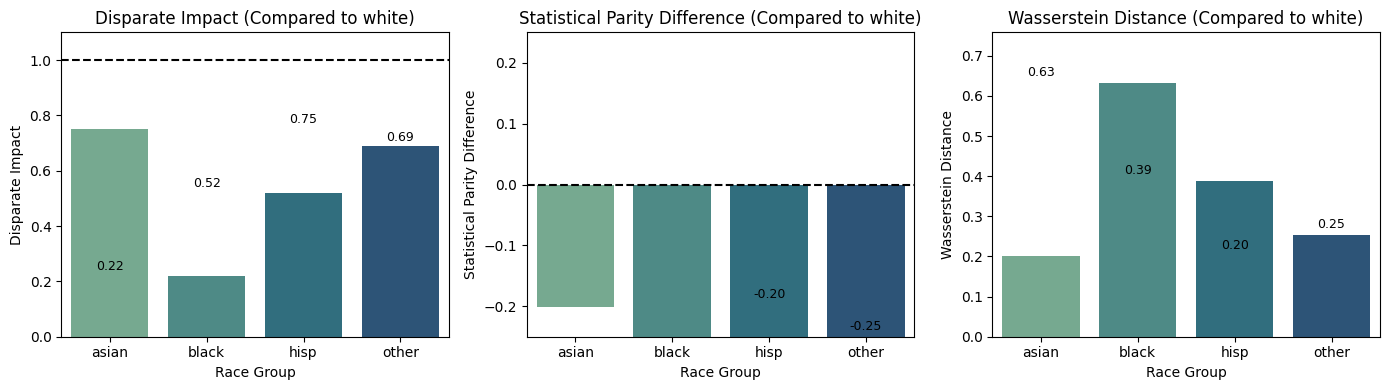

In [51]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_xgb_rw')
plot_fairness_metrics(results, 'Race Group', 'white')

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

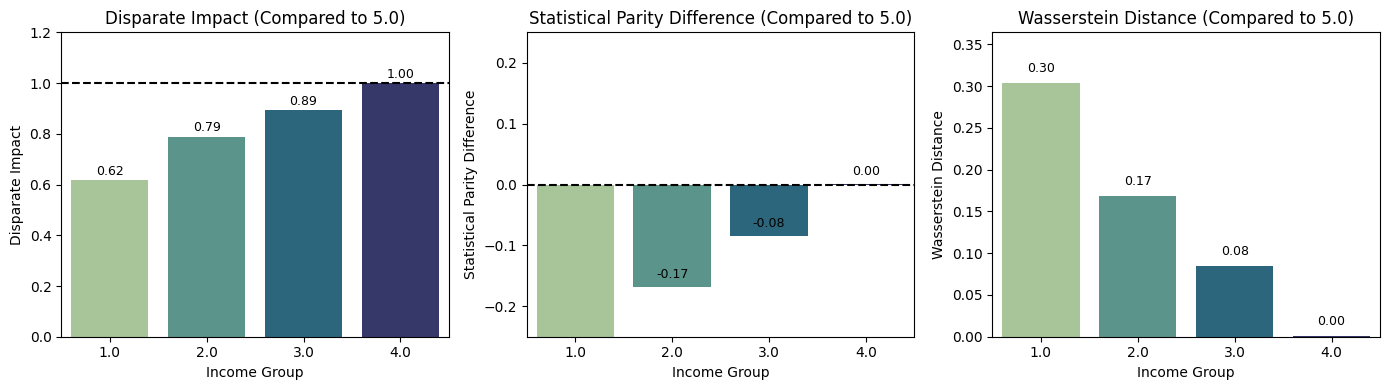

In [52]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_xgb_rw')
plot_fairness_metrics(results, 'Income Group', 5.0)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

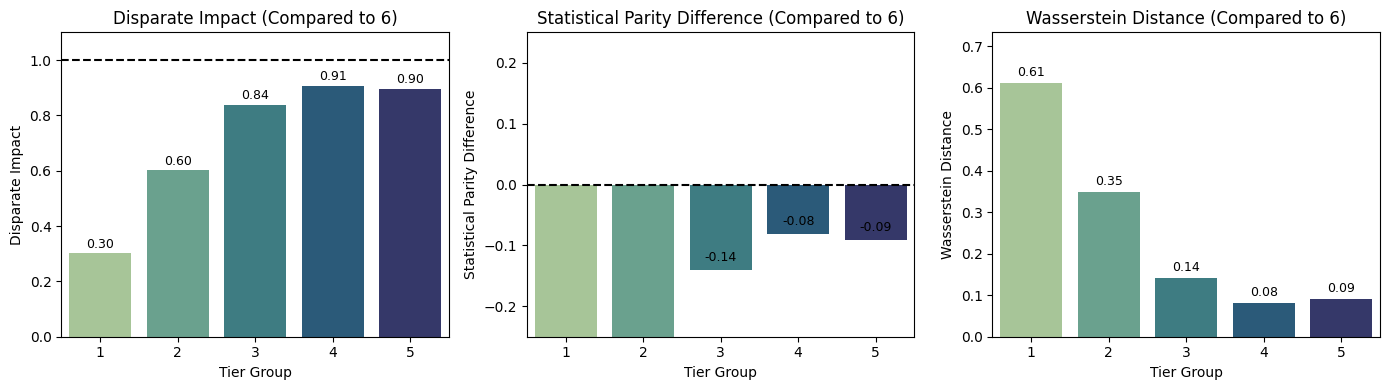

In [53]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_xgb_rw')
plot_fairness_metrics(results, 'Tier Group', 6)